In [1]:
from ipfn import ipfn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
#df_dtypes = {'IncRespondent2000' : 'int32',  'Sector' : 'category', 
 #            'DiaryMonth' : 'category', 'DiaryWeekday' : 'category', 'Handicap': 'category', 
  #           'MunicipalityOrigin': 'category', 'MunicipalityDest': 'category', 'AgeGroup': 'category', 
   #          'edu': 'category', 'RespEdulevel': 'category', 'RespHasBicycle': 'category', 
    #         'ResphasDrivlic': 'category', 'RespPrimOcc': 'category', 'Gender': 'category', 'WorkHourType': 'category', 
     #        'PopSocio': 'category', 'RespHasRejsekort': 'category', 'RespIsmemCarshare': 'category', 
      #       'Sector': 'category','HomeAdrDistNearestStation' : 'float64',  'IncFamily2000' : 'float64', 
       #      'IncHouseh2000' : 'float64',  'IncRespondent2000' : 'category',  
        #     'SessionId' : 'float64',   'HwDayspW' : 'float64',  'WorkHoursPw' : 'float64',  'FamNumAdults' : 'float64', 
         #    'FamNumPers' : 'float64',  'HousehCarOwnership' : 'float64', 'HousehNumAdults' : 'float64', 
          #   'HousehNumcars' : 'float64',  'HousehNumPers' : 'float64',  'Year' : 'float64',  'TotalNumTrips':'float64'}
os.chdir('/Users/siggahalldorsdottir/Documents/THESIS/Code/MSc_PopSyn/Sigga_Luis/Data')
samp_df = pd.read_csv('wgan_samples.txt', sep=',')
samp_df_all = samp_df

samp_df = samp_df.loc[samp_df['MunicipalityOrigin'].isin([751, 657, 779, 540, 410, 147, 169, 219, 190, 360, 253, 530, 851,
       615, 376, 630, 259, 813, 165, 101, 306, 210, 575, 336, 461, 230,
       159, 840, 183, 185, 561, 350, 706, 621, 810, 173, 580, 250, 727,
       510, 740, 217, 163, 270, 265, 201, 746, 791, 430, 787, 400, 260,
       223, 390, 370, 340, 330, 157, 420, 671, 240, 730, 161, 167, 661,
       573, 860, 766, 316, 710, 756, 151, 550, 329, 773, 153, 326, 607,
       320, 480, 269, 492, 175, 482, 846, 665, 760, 563, 450, 440, 820,
       479, 707, 849, 155, 187, 825, 741])]

samp_df['Gender'] = samp_df.Gender.astype('category').cat.rename_categories({1.: 'M', 2.: 'K'})

In [37]:
os.chdir('/Users/siggahalldorsdottir/Documents/THESIS/Code/Data')
income_code = pd.read_csv('INDKP105_code.csv', sep=';')
income_value = pd.read_csv('INDKP105_value.csv', sep=';')

income_code['id'] = income_code.index
income_value['id'] = income_value.index

income = income_code.merge(income_value, on='id', suffixes=('_c', '_v'))
income = income[['OMRÅDE_c','KOEN_c','ALDER1_v','INDKINTB_v','INDHOLD_c']]
income = income.loc[income['OMRÅDE_c'].isin(samp_df['MunicipalityOrigin'].unique())]
income = income.rename(columns = {'KOEN_c':'Gender', 'OMRÅDE_c':'MunicipalityOrigin', 'KOEN_c':'Gender', 'ALDER1_v': 'AgeGroup','INDKINTB_v':'IncRespondent2000','INDHOLD_c':'total'})
income = income.drop(income.index[income.total == '..'])
income['total'] = income.total.astype('float64')

income = income.loc[income['AgeGroup'].isin(['60-64 years', '45-49 years', '20-24 years', '15-19 years',
       '65-69 years', '50-54 years', '55-59 years', '25-29 years',
       '35-39 years', '40-44 years', '30-34 years'])]

In [4]:
def genPopIPF(df, attr, dist):
    group = list(set([item for sublist in attr for item in sublist]))
    Init = pd.DataFrame(df.groupby(group, as_index=False).size())
    
    Init = Init.rename(columns={'size':'total'})
    Init['total']= Init['total'].replace(0,0.01)
    IPF = ipfn.ipfn(Init, dist, attr)
    sol = IPF.iteration()
    
    final = sample(sol, df)
    
    return final
    

In [5]:
def sample(IPF, df):
    final = pd.DataFrame()
    sampled_groups = []
    
    for _, row in IPF.iterrows():
        conditions = [df[attr] == row[attr] for attr in IPF.columns[:-1]]
        mask = pd.concat(conditions, axis=1).all(axis=1)
    
        if mask.any():
            group = df[mask]
            new = group.sample(n=round(row['total']), replace=True, ignore_index=True)
            sampled_groups.append(new)
    
    return pd.concat(sampled_groups, ignore_index=True)


In [6]:
#IPF
ag1 = income.groupby(['MunicipalityOrigin'])['total'].sum()
ag2 = income.groupby(['Gender'])['total'].sum()
ag3 = income.groupby(['AgeGroup'])['total'].sum()
ag4 = income.groupby(['IncRespondent2000'])['total'].sum()

dimensions = [['MunicipalityOrigin'],['Gender'],['AgeGroup'],['IncRespondent2000']]
#dimensions = [['Gender']]
aggregates = [ag1, ag2, ag3, ag4]

In [7]:
df = genPopIPF(samp_df, dimensions, aggregates)

In [19]:
df.to_csv('populationfinal.txt', sep=',', index=False)

In [17]:
df

,HomeAdrDistNearestStation,IncFamily2000,IncHouseh2000,HwDayspW,WorkHoursPw,FamNumAdults,FamNumPers,HousehCarOwnership,HousehNumAdults,HousehNumcars,...,WorkHourType,Sector,PopSocio,DayStartGMMzone,HomeAdrGMMzone,JstartGMMzone,PrimOccGMMzone,SduGMMzone,RespHasRejsekort,RespIsmemCarshare
0,"(-0.001, 0.4]","(-0.001, 112.0]","(-0.001, 123.0]","(-0.001, 3.0]","(-0.001, 30.0]","(-0.001, 1.0]","(0.999, 2.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]",...,0,Activity not stated,3,730324.0,147233.0,MISSING,MISSING,MISSING,1.0,2.0
1,"(-0.001, 0.4]","(-0.001, 112.0]","(-0.001, 123.0]","(-0.001, 3.0]","(-0.001, 30.0]","(-0.001, 1.0]","(0.999, 2.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]",...,0,Activity not stated,3,147233.0,147233.0,MISSING,MISSING,MISSING,1.0,1.0
2,"(-0.001, 0.4]","(427.0, 475.0]","(443.0, 487.0]","(4.0, 5.0]","(-0.001, 30.0]","(1.0, 2.0]","(2.0, 3.0]","(-0.001, 1.0]","(1.0, 2.0]","(-0.001, 1.0]",...,0,Activity not stated,0,102543.0,102822.0,103174.0,147162.0,MISSING,20.0,1.0
3,"(-0.001, 0.4]","(320.0, 371.429]","(331.0, 386.0]","(4.0, 5.0]","(-0.001, 30.0]","(2.0, 3.0]","(4.0, 5.0]","(-0.001, 1.0]","(2.0, 3.0]","(-0.001, 1.0]",...,0,Wholesale and retail trade,0,103172.0,147161.0,147161.0,147162.0,851761.0,2.0,2.0
4,"(14.2, 54.5]","(221.0, 268.0]","(234.0, 280.0]","(4.0, 5.0]","(-0.001, 30.0]","(-0.001, 1.0]","(0.999, 2.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]",...,0,Activity not stated,0,102633.0,147161.0,147233.0,MISSING,MISSING,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3900346,"(0.7, 0.9]","(169.0, 221.0]","(123.0, 185.0]","(-0.001, 3.0]","(-0.001, 30.0]","(1.0, 2.0]","(0.999, 2.0]","(-0.001, 1.0]","(1.0, 2.0]","(-0.001, 1.0]",...,0,Activity not stated,3,751129.0,751115.0,MISSING,MISSING,MISSING,20.0,2.0
3900347,"(0.7, 0.9]","(169.0, 221.0]","(123.0, 185.0]","(-0.001, 3.0]","(-0.001, 30.0]","(1.0, 2.0]","(0.999, 2.0]","(-0.001, 1.0]","(1.0, 2.0]","(-0.001, 1.0]",...,0,Activity not stated,3,751129.0,751115.0,MISSING,MISSING,MISSING,20.0,2.0
3900348,"(14.2, 54.5]","(169.0, 221.0]","(185.0, 234.0]","(-0.001, 3.0]","(-0.001, 30.0]","(1.0, 2.0]","(0.999, 2.0]","(-0.001, 1.0]","(1.0, 2.0]","(-0.001, 1.0]",...,0,Activity not stated,3,851514.0,710074.0,MISSING,MISSING,MISSING,6.0,2.0
3900349,"(1.8, 2.4]","(169.0, 221.0]","(123.0, 185.0]","(-0.001, 3.0]","(-0.001, 30.0]","(1.0, 2.0]","(0.999, 2.0]","(-0.001, 1.0]","(1.0, 2.0]","(-0.001, 1.0]",...,0,Activity not stated,3,169052.0,153034.0,MISSING,MISSING,MISSING,30.0,2.0


In [23]:
n=500000

income['total'] = income['total']/income['total'].sum()

ag1 = income.groupby(['MunicipalityOrigin'])['total'].sum()*n
ag2 = income.groupby(['Gender'])['total'].sum()*n

dimensions = [['MunicipalityOrigin'],['Gender']]
aggregates = [ag1, ag2]
df2 = genPopIPF(samp_df, dimensions, aggregates)
df2

,HomeAdrDistNearestStation,IncFamily2000,IncHouseh2000,HwDayspW,WorkHoursPw,FamNumAdults,FamNumPers,HousehCarOwnership,HousehNumAdults,HousehNumcars,...,WorkHourType,Sector,PopSocio,DayStartGMMzone,HomeAdrGMMzone,JstartGMMzone,PrimOccGMMzone,SduGMMzone,RespHasRejsekort,RespIsmemCarshare
0,"(1.4, 1.8]","(-0.001, 112.0]","(123.0, 185.0]","(-0.001, 3.0]","(-0.001, 30.0]","(-0.001, 1.0]","(3.0, 4.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]",...,0,Activity not stated,2,751433.0,102671.0,MISSING,MISSING,MISSING,5.0,2.0
1,"(1.8, 2.4]","(112.0, 169.0]","(631.0, 711.0]","(-0.001, 3.0]","(-0.001, 30.0]","(2.0, 3.0]","(3.0, 4.0]","(-0.001, 1.0]","(2.0, 3.0]","(-0.001, 1.0]",...,4.0,Activity not stated,2,102343.0,102543.0,MISSING,MISSING,MISSING,2.0,2.0
2,"(0.5, 0.7]","(616.0, 688.0]","(631.0, 711.0]","(4.0, 5.0]","(34.0, 37.0]","(1.0, 2.0]","(3.0, 4.0]","(-0.001, 1.0]","(1.0, 2.0]","(-0.001, 1.0]",...,1.0,Wholesale and retail trade,1,102411.0,102533.0,102343.0,163016.0,102343.0,2.0,2.0
3,"(-0.001, 0.4]","(-0.001, 112.0]","(-0.001, 123.0]","(-0.001, 3.0]","(-0.001, 30.0]","(1.0, 2.0]","(0.999, 2.0]","(-0.001, 1.0]","(1.0, 2.0]","(-0.001, 1.0]",...,0,Activity not stated,0,102543.0,102543.0,MISSING,MISSING,MISSING,2.0,2.0
4,"(-0.001, 0.4]","(813.0, 38376.0]","(811.0, 790854.0]","(4.0, 5.0]","(37.0, 45.0]","(2.0, 3.0]","(2.0, 3.0]","(-0.001, 1.0]","(2.0, 3.0]","(-0.001, 1.0]",...,MISSING,Wholesale and retail trade,1,102343.0,102343.0,159077.0,102851.0,147161.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499992,"(0.7, 0.9]","(371.429, 427.0]","(386.0, 443.0]","(-0.001, 3.0]","(-0.001, 30.0]","(1.0, 2.0]","(0.999, 2.0]","(-0.001, 1.0]","(1.0, 2.0]","(-0.001, 1.0]",...,0,Activity not stated,3,929150.0,751115.0,MISSING,MISSING,MISSING,35.0,2.0
499993,"(1.8, 2.4]","(518.0, 568.0]","(531.0, 577.0]","(-0.001, 3.0]","(-0.001, 30.0]","(2.0, 3.0]","(0.999, 2.0]","(-0.001, 1.0]","(2.0, 3.0]","(-0.001, 1.0]",...,2.0,"Public administration, defence and compulsory ...",1,163031.0,102672.0,MISSING,MISSING,MISSING,2.0,2.0
499994,"(1.1, 1.4]","(688.0, 813.0]","(711.0, 811.0]","(4.0, 5.0]","(-0.001, 30.0]","(2.0, 3.0]","(3.0, 4.0]","(1.0, 2.0]","(2.0, 3.0]","(1.0, 2.0]",...,2.0,Education,1,165013.0,147111.0,730352.0,851731.0,165013.0,20.0,2.0
499995,"(6.5, 9.8]","(320.0, 371.429]","(331.0, 386.0]","(4.0, 5.0]","(34.0, 37.0]","(2.0, 3.0]","(2.0, 3.0]","(1.0, 2.0]","(2.0, 3.0]","(1.0, 2.0]",...,1.0,Accommodation and food service activities,1,479116.0,102672.0,479116.0,740133.0,336021.0,2.0,2.0


In [15]:
df2 = genPopIPF(samp_df, dimensions, aggregates)

In [20]:
income.groupby(['Gender'])['total'].sum()

Gender
K    0.497036
M    0.502964
Name: total, dtype: float64

In [26]:
n=500000
data = {'K': 0.30, 'M': 0.70}
ag1 = pd.Series(data, name='total')
ag1.index.name = 'Gender'
ag1 = ag1*n
ag2 = income.groupby(['MunicipalityOrigin'])['total'].sum()*n
ag3 = income.groupby(['AgeGroup'])['total'].sum()*n
ag4 = income.groupby(['IncRespondent2000'])['total'].sum()*n

dimensions = [['Gender'],['MunicipalityOrigin'],['AgeGroup'],['IncRespondent2000']]
aggregates = [ag1, ag2, ag3, ag4]
df3 = genPopIPF(samp_df, dimensions, aggregates)

In [27]:
df3.head()

,HomeAdrDistNearestStation,IncFamily2000,IncHouseh2000,HwDayspW,WorkHoursPw,FamNumAdults,FamNumPers,HousehCarOwnership,HousehNumAdults,HousehNumcars,...,WorkHourType,Sector,PopSocio,DayStartGMMzone,HomeAdrGMMzone,JstartGMMzone,PrimOccGMMzone,SduGMMzone,RespHasRejsekort,RespIsmemCarshare
0,"(-0.001, 0.4]","(-0.001, 112.0]","(331.0, 386.0]","(4.0, 5.0]","(-0.001, 30.0]","(1.0, 2.0]","(0.999, 2.0]","(-0.001, 1.0]","(1.0, 2.0]","(-0.001, 1.0]",...,0,Wholesale and retail trade,0,370133.0,102343.0,MISSING,147162.0,MISSING,40.0,2.0
1,"(-0.001, 0.4]","(518.0, 568.0]","(531.0, 577.0]","(4.0, 5.0]","(-0.001, 30.0]","(2.0, 3.0]","(2.0, 3.0]","(-0.001, 1.0]","(2.0, 3.0]","(-0.001, 1.0]",...,0,Consultancy etc.,0,147161.0,147161.0,147161.0,103181.0,102343.0,6.0,2.0
2,"(6.5, 9.8]","(-0.001, 112.0]","(-0.001, 123.0]","(4.0, 5.0]","(-0.001, 30.0]","(-0.001, 1.0]","(0.999, 2.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]",...,0,Activity not stated,0,102543.0,102543.0,MISSING,MISSING,MISSING,2.0,1.0
3,"(-0.001, 0.4]","(-0.001, 112.0]","(-0.001, 123.0]","(-0.001, 3.0]","(-0.001, 30.0]","(1.0, 2.0]","(0.999, 2.0]","(-0.001, 1.0]","(1.0, 2.0]","(-0.001, 1.0]",...,0,Activity not stated,0,751129.0,102343.0,MISSING,MISSING,MISSING,1.0,1.0
4,"(-0.001, 0.4]","(-0.001, 112.0]","(-0.001, 123.0]","(-0.001, 3.0]","(-0.001, 30.0]","(-0.001, 1.0]","(0.999, 2.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]",...,0,Activity not stated,3,103172.0,147233.0,MISSING,MISSING,MISSING,2.0,1.0


ValueError: could not broadcast input array from shape (5,1) into shape (5,)

In [49]:
income.groupby(['IncRespondent2000'])['total'].sum().index

Index(['100,000 - 124,999 DKK', '125,000 - 149,999 DKK',
       '150,000 - 174,999 DKK', '175,000 - 199,999 DKK',
       '200,000 - 224,999 DKK', '225,000 - 249,999 DKK', '25,000 - 49,999 DKK',
       '250,000 - 299,999 DKK', '300,000 - 349,999 DKK',
       '350,000 - 399,999 DKK', '400,000 - 449,999 DKK',
       '450,000 - 499,999 DKK', '50,000 - 74,999 DKK', '500,000 DKK and more',
       '75,000 - 99,999 DKK', 'Under 25,000 DKK'],
      dtype='object', name='IncRespondent2000')

In [66]:
pd.DataFrame(pd.value_counts(df['IncRespondent2000'])).join(income.groupby(['IncRespondent2000'])['total'].sum())

,count,total
IncRespondent2000,,
"500,000 DKK and more",884679,903373.0
"350,000 - 399,999 DKK",351006,354835.0
"400,000 - 449,999 DKK",339182,343681.0
"250,000 - 299,999 DKK",336116,336636.0
"300,000 - 349,999 DKK",320941,322444.0
"450,000 - 499,999 DKK",273481,284113.0
"Under 25,000 DKK",248488,250493.0
"225,000 - 249,999 DKK",206196,206705.0
"175,000 - 199,999 DKK",162203,162935.0


In [76]:
def plotIPF(df_gen, df_ipf, attr):
    group = list(set([item for sublist in attr for item in sublist]))
    for col in group:
        df_plot = pd.DataFrame(pd.value_counts(df_ipf[col], normalize=True)).join(pd.value_counts(df_gen, normalize=True), lsuffix='_IPF', rsuffix='_Gen')
        df_plot.plot(kind='bar')



In [74]:
df_plot = pd.DataFrame(pd.value_counts(df['IncRespondent2000'], normalize=True)).join(pd.value_counts(samp_df['IncRespondent2000'], normalize=True), lsuffix='_IPF', rsuffix='_Gen')





In [65]:
pd.value_counts(samp_df['IncRespondent2000'])

IncRespondent2000
250,000 - 299,999 DKK    178298
225,000 - 249,999 DKK    103559
300,000 - 349,999 DKK     89656
150,000 - 174,999 DKK     72418
200,000 - 224,999 DKK     70615
125,000 - 149,999 DKK     63710
100,000 - 124,999 DKK     61887
175,000 - 199,999 DKK     59890
75,000 - 99,999 DKK       55228
50,000 - 74,999 DKK       49079
350,000 - 399,999 DKK     44530
Under 25,000 DKK          43417
500,000 DKK and more      34458
400,000 - 449,999 DKK     32759
25,000 - 49,999 DKK       23556
450,000 - 499,999 DKK     16940
Name: count, dtype: int64

In [63]:
pd.DataFrame(pd.value_counts(df['IncRespondent2000'])).join(pd.value_counts(samp_df['IncRespondent2000']))

ValueError: columns overlap but no suffix specified: Index(['count'], dtype='object')

In [61]:
df_plot.rename(columns = {'count':'IPF', 'total':'marginals'}, inplace=True)

<Axes: xlabel='IncRespondent2000'>

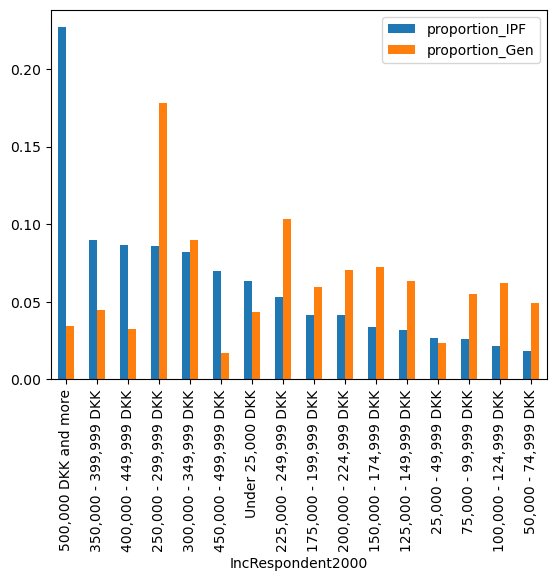

In [75]:
df_plot.plot(kind='bar')

<Axes: xlabel='total'>

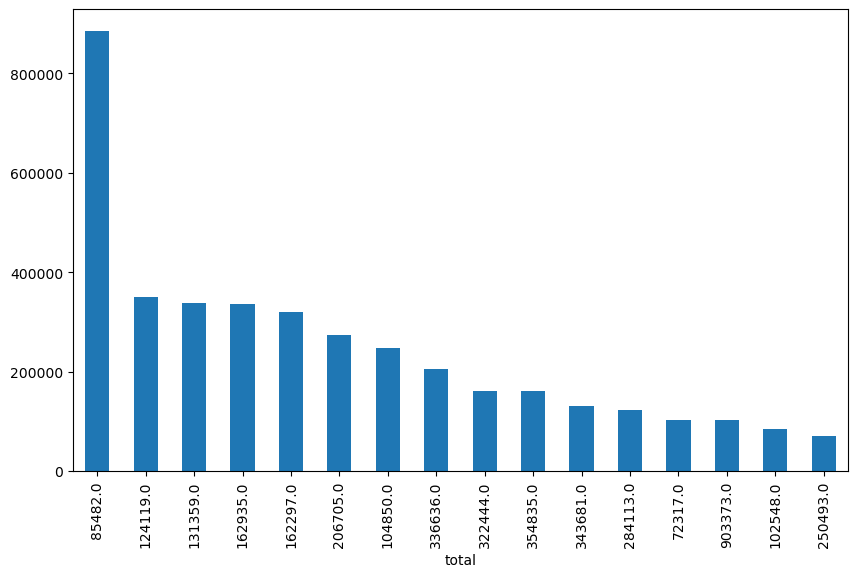

In [39]:
plt.figure(figsize=(10,6))
ax = pd.value_counts(df['IncRespondent2000']).plot(kind='bar')
pd.value_counts(income.groupby(['IncRespondent2000'])['total'].sum()).plot(kind='bar', ax=ax)

In [ ]:
ax = df1.plot()
df2.plot(ax=ax)

In [178]:
for _, row in df.iterrows():
        conditions = [samp_df[attr] == row[attr] for attr in df.columns[:-1]]
        print(conditions)
        #mask = any(condition.all() for condition in conditions)

[0        False
1         True
2        False
3         True
4         True
         ...  
99995    False
99996     True
99997     True
99998    False
99999    False
Name: Gender, Length: 100000, dtype: bool]
[0         True
1        False
2         True
3        False
4        False
         ...  
99995     True
99996    False
99997    False
99998     True
99999     True
Name: Gender, Length: 100000, dtype: bool]


In [185]:
df[conditions].all(axis=1)

KeyError: "None of [Index([(True, False, True, False, False, True, True, False, True, True, True, True, True, False, False, True, True, True, False, True, False, True, False, True, True, False, True, True, False, True, False, True, False, True, False, True, True, False, False, True, False, False, True, False, False, True, True, True, False, True, True, True, True, True, False, True, False, False, True, True, True, False, False, True, False, False, False, False, True, True, False, False, True, False, True, True, True, False, True, True, True, True, False, True, False, True, True, True, True, True, True, True, True, True, False, True, False, True, True, False, ...)], dtype='object')] are in the [columns]"

In [138]:
ag1 = income.groupby(['MunicipalityOrigin','Gender','AgeGroup'])['total'].sum()
ag2 = income.groupby(['MunicipalityOrigin', 'Gender', 'IncRespondent2000'])['total'].sum()
Init = samp_df
#Init = pd.DataFrame(samp_df.groupby(['MunicipalityOrigin', 'Gender', 'AgeGroup', 'IncRespondent2000'], as_index=False).size())
#Init = Init.rename(columns={'size':'total'})
#Init['MunicipalityOrigin'] = Init['MunicipalityOrigin'].astype('category')
#Init['total']= Init['total'].replace(0,0.01)
dimensions = [['MunicipalityOrigin','Gender','AgeGroup'], ['MunicipalityOrigin', 'Gender', 'IncRespondent2000']]
aggregates = [ag1, ag2]

IPF = ipfn.ipfn(Init, aggregates, dimensions)
df = IPF.iteration()

KeyError: 'Column not found: total'

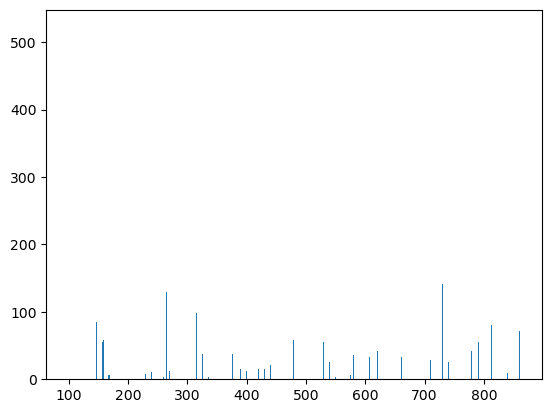

In [117]:
#plotta meira
plt.bar(Init['MunicipalityOrigin'], Init['total'])
plt.show()

In [118]:
pd.DataFrame(samp_df.groupby(['MunicipalityOrigin', 'Gender', 'AgeGroup', 'IncRespondent2000'], as_index=False).size())

,MunicipalityOrigin,Gender,AgeGroup,IncRespondent2000,size
0,101,M,15-19 years,"100,000 - 124,999 DKK",7
1,101,M,15-19 years,"125,000 - 149,999 DKK",8
2,101,M,15-19 years,"150,000 - 174,999 DKK",4
3,101,M,15-19 years,"175,000 - 199,999 DKK",0
4,101,M,15-19 years,"200,000 - 224,999 DKK",5
...,...,...,...,...,...
31323,860,K,65-69 years,"450,000 - 499,999 DKK",0
31324,860,K,65-69 years,"50,000 - 74,999 DKK",0
31325,860,K,65-69 years,"500,000 DKK and more",0
31326,860,K,65-69 years,"75,000 - 99,999 DKK",17


In [119]:
#IPF
dimensions = [['MunicipalityOrigin','Gender','AgeGroup'], ['MunicipalityOrigin', 'Gender', 'IncRespondent2000']]
aggregates = [ag1, ag2]

IPF = ipfn.ipfn(Init, aggregates, dimensions)
df = IPF.iteration()

In [120]:
df

,MunicipalityOrigin,Gender,IncRespondent2000,AgeGroup,total
0,101,M,"100,000 - 124,999 DKK",15-19 years,54.795388
1,101,M,"100,000 - 124,999 DKK",20-24 years,747.172782
2,101,M,"100,000 - 124,999 DKK",25-29 years,1764.952199
3,101,M,"100,000 - 124,999 DKK",30-34 years,635.038429
4,101,M,"100,000 - 124,999 DKK",35-39 years,195.332076
...,...,...,...,...,...
31323,860,K,"Under 25,000 DKK",45-49 years,0.225227
31324,860,K,"Under 25,000 DKK",50-54 years,0.600846
31325,860,K,"Under 25,000 DKK",55-59 years,0.129593
31326,860,K,"Under 25,000 DKK",60-64 years,1.834047


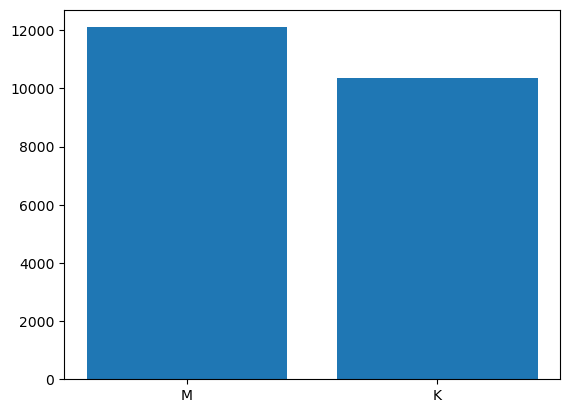

In [84]:
plt.bar(df['Gender'], df['total'])
plt.show()

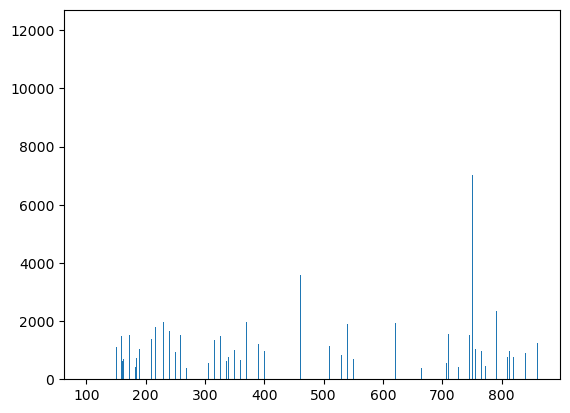

In [85]:
plt.bar(df['MunicipalityOrigin'], df['total'])
plt.show()

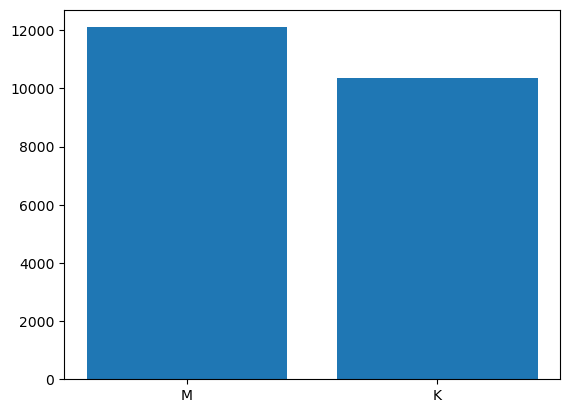

In [86]:
plt.bar(Init['Gender'], Init['total'])
plt.show()

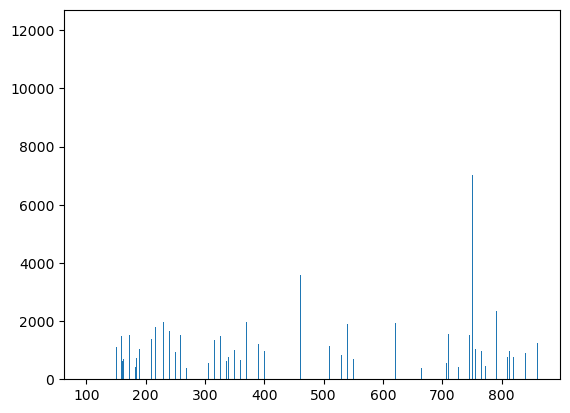

In [87]:
plt.bar(Init['MunicipalityOrigin'], Init['total'])
plt.show()

In [88]:
df

,MunicipalityOrigin,Gender,IncRespondent2000,AgeGroup,total
0,101,M,"100,000 - 124,999 DKK",15-19 years,54.795388
1,101,M,"100,000 - 124,999 DKK",20-24 years,747.172782
2,101,M,"100,000 - 124,999 DKK",25-29 years,1764.952199
3,101,M,"100,000 - 124,999 DKK",30-34 years,635.038429
4,101,M,"100,000 - 124,999 DKK",35-39 years,195.332076
...,...,...,...,...,...
31323,860,K,"Under 25,000 DKK",45-49 years,0.225227
31324,860,K,"Under 25,000 DKK",50-54 years,0.600846
31325,860,K,"Under 25,000 DKK",55-59 years,0.129593
31326,860,K,"Under 25,000 DKK",60-64 years,1.834047


In [89]:
Init

,MunicipalityOrigin,Gender,IncRespondent2000,AgeGroup,total
0,101,M,"100,000 - 124,999 DKK",15-19 years,54.795388
1,101,M,"100,000 - 124,999 DKK",20-24 years,747.172782
2,101,M,"100,000 - 124,999 DKK",25-29 years,1764.952199
3,101,M,"100,000 - 124,999 DKK",30-34 years,635.038429
4,101,M,"100,000 - 124,999 DKK",35-39 years,195.332076
...,...,...,...,...,...
31323,860,K,"Under 25,000 DKK",45-49 years,0.225227
31324,860,K,"Under 25,000 DKK",50-54 years,0.600846
31325,860,K,"Under 25,000 DKK",55-59 years,0.129593
31326,860,K,"Under 25,000 DKK",60-64 years,1.834047


In [121]:
def sampleIPF(IPF, df):
    final = pd.DataFrame()
    for row in IPF.iterrows():
        group = df.loc[(df['Gender']==row[1]['Gender']) & (df['AgeGroup'] == row[1]['AgeGroup']) & (df['MunicipalityOrigin'] == row[1]['MunicipalityOrigin'])  & (df['IncRespondent2000'] == row[1]['IncRespondent2000'])]
        if len(group) != 0:    
            new = group.sample(n=round(row[1]['total']), replace=True, ignore_index=True)
            final = pd.concat([final, new])
    return final

In [122]:
final = sampleIPF(df, samp_df)

KeyboardInterrupt: 

In [60]:
len(samp_df)

5000000

In [61]:
data = pd.DataFrame(samp_df.groupby(['MunicipalityOrigin', 'Gender', 'AgeGroup', 'IncRespondent2000'], as_index=False).size())

In [62]:
data1 = data.set_index(['MunicipalityOrigin', 'Gender', 'AgeGroup', 'IncRespondent2000'])
data2 = income.set_index(['MunicipalityOrigin', 'Gender', 'AgeGroup', 'IncRespondent2000'])

In [63]:
index = data1.join(data2, how='inner')

In [64]:
pd.DataFrame(np.setdiff1d(data1.index, data2.index))

,0
0,"(101, K, 15-19 years, 400,000 - 449,999 DKK)"
1,"(101, M, 15-19 years, 350,000 - 399,999 DKK)"
2,"(101, M, 15-19 years, 450,000 - 499,999 DKK)"
3,"(147, K, 15-19 years, 300,000 - 349,999 DKK)"
4,"(147, K, 15-19 years, 350,000 - 399,999 DKK)"
...,...
2517,"(860, M, 15-19 years, 450,000 - 499,999 DKK)"
2518,"(860, M, 35-39 years, 25,000 - 49,999 DKK)"
2519,"(860, M, 40-44 years, 25,000 - 49,999 DKK)"
2520,"(860, M, 40-44 years, 50,000 - 74,999 DKK)"


In [25]:
final.head()

,HomeAdrDistNearestStation,IncFamily2000,IncHouseh2000,HwDayspW,WorkHoursPw,FamNumAdults,FamNumPers,HousehCarOwnership,HousehNumAdults,HousehNumcars,...,RespEdulevel,RespHasBicycle,ResphasDrivlic,RespPrimOcc,Gender,WorkHourType,Sector,PopSocio,RespHasRejsekort,RespIsmemCarshare
0,"(0.5, 0.7]","(258.0, 303.0]","(-0.001, 100.0]","(-0.001, 3.0]","(-0.001, 28.0]","(1.0, 2.0]","(2.0, 3.0]","(-0.001, 1.0]","(1.0, 2.0]","(-0.001, 1.0]",...,3.0,2.0,2.0,350.0,M,0,Activity not stated,3,2.0,2.0
1,"(-0.001, 0.4]","(-0.001, 97.0]","(100.0, 161.0]","(-0.001, 3.0]","(-0.001, 28.0]","(-0.001, 1.0]","(0.999, 2.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]",...,3.0,1.0,2.0,370.0,M,0,Activity not stated,3,1.0,2.0
2,"(-0.001, 0.4]","(463.0, 509.0]","(468.0, 513.0]","(4.0, 5.0]","(-0.001, 28.0]","(1.0, 2.0]","(0.999, 2.0]","(-0.001, 1.0]","(1.0, 2.0]","(-0.001, 1.0]",...,4.0,1.0,2.0,310.0,M,0,Activity not stated,0,6.0,2.0
3,"(0.4, 0.5]","(509.0, 555.0]","(513.0, 559.0]","(4.0, 5.0]","(-0.001, 28.0]","(1.0, 2.0]","(3.0, 4.0]","(-0.001, 1.0]","(1.0, 2.0]","(-0.001, 1.0]",...,4.0,1.0,1.0,116.0,M,0,Construction,0,20.0,2.0
4,"(-0.001, 0.4]","(509.0, 555.0]","(100.0, 161.0]","(3.0, 4.0]","(-0.001, 28.0]","(1.0, 2.0]","(3.0, 4.0]","(-0.001, 1.0]","(1.0, 2.0]","(-0.001, 1.0]",...,4.0,2.0,2.0,116.0,M,0,Activity not stated,0,10.0,2.0


In [ ]:
Init3D = pd.DataFrame(samp_df.groupby(['Gender', 'MunicipalityOrigin','AgeGroup', 'Inc'], as_index=False).size())
Init3D = Init3D.rename(columns={'size':'total'})
Init['MunicipalityOrigin'] = Init['MunicipalityOrigin'].astype('category')
Init['total']= Init['total'].replace(0,0.01)

In [ ]:
#IPF 3D


In [ ]:
os.chdir('/Users/siggahalldorsdottir/Documents/THESIS/Code/MSc_PopSyn')
import Plot_utils

In [44]:
#IPF
ag1 = income.groupby(['MunicipalityOrigin'])['total'].sum()
ag2 = income.groupby(['Gender'])['total'].sum()
ag3 = income.groupby(['AgeGroup'])['total'].sum()
Init = pd.DataFrame(samp_df.groupby(['MunicipalityOrigin', 'Gender', 'AgeGroup'], as_index=False).size())
Init = Init.rename(columns={'size':'total'})
#Init['MunicipalityOrigin'] = Init['MunicipalityOrigin'].astype('category')
Init['total']= Init['total'].replace(0,0.01)
dimensions = [['MunicipalityOrigin'],['Gender'],['AgeGroup']]
aggregates = [ag1, ag2, ag3]

IPF = ipfn.ipfn(Init, aggregates, dimensions)
df = IPF.iteration()

In [45]:
df

,AgeGroup,MunicipalityOrigin,Gender,total
0,15-19 years,101,M,13087.130928
1,20-24 years,101,M,41299.755803
2,25-29 years,101,M,50756.683068
3,30-34 years,101,M,33359.687658
4,35-39 years,101,M,17462.359892
...,...,...,...,...
2107,45-49 years,860,K,2546.634412
2108,50-54 years,860,K,2188.908243
2109,55-59 years,860,K,2484.330911
2110,60-64 years,860,K,2418.209524


In [123]:
#IPF
ag1 = income.groupby(['MunicipalityOrigin'])['total'].sum()
ag2 = income.groupby(['Gender'])['total'].sum()
Init = pd.DataFrame(samp_df.groupby(['MunicipalityOrigin', 'Gender'], as_index=False).size())
Init = Init.rename(columns={'size':'total'})
#Init['MunicipalityOrigin'] = Init['MunicipalityOrigin'].astype('category')
Init['total']= Init['total'].replace(0,0.01)
dimensions = [['MunicipalityOrigin'],['Gender']]
aggregates = [ag1, ag2, ag3]

IPF = ipfn.ipfn(Init, aggregates, dimensions)
df = IPF.iteration()

In [129]:
final = sampleIPF(df, samp_df)

In [131]:
len(final)

3901623

In [132]:
final.to_csv('population.txt', sep=',', index=False)

In [46]:
#IPF
ag1 = income.groupby(['MunicipalityOrigin'])['total'].sum()
ag2 = income.groupby(['Gender'])['total'].sum()
ag3 = income.groupby(['AgeGroup'])['total'].sum()
ag4 = income.groupby(['IncRespondent2000'])['total'].sum()
Init = pd.DataFrame(samp_df.groupby(['MunicipalityOrigin', 'Gender', 'AgeGroup', 'IncRespondent2000'], as_index=False).size())
Init = Init.rename(columns={'size':'total'})
#Init['MunicipalityOrigin'] = Init['MunicipalityOrigin'].astype('category')
Init['total']= Init['total'].replace(0,0.01)
dimensions = [['MunicipalityOrigin'],['Gender'],['AgeGroup'],['IncRespondent2000']]
aggregates = [ag1, ag2, ag3, ag4]

IPF = ipfn.ipfn(Init, aggregates, dimensions)
df = IPF.iteration()

In [47]:
df

,IncRespondent2000,MunicipalityOrigin,Gender,AgeGroup,total
0,"100,000 - 124,999 DKK",101,M,15-19 years,64.202230
1,"125,000 - 149,999 DKK",101,M,15-19 years,93.347682
2,"150,000 - 174,999 DKK",101,M,15-19 years,47.899503
3,"175,000 - 199,999 DKK",101,M,15-19 years,70.464459
4,"200,000 - 224,999 DKK",101,M,15-19 years,41.012186
...,...,...,...,...,...
33787,"450,000 - 499,999 DKK",860,K,65-69 years,7.962011
33788,"50,000 - 74,999 DKK",860,K,65-69 years,11.264262
33789,"500,000 DKK and more",860,K,65-69 years,57.418927
33790,"75,000 - 99,999 DKK",860,K,65-69 years,142.147898


In [75]:
income

,MunicipalityOrigin,Gender,AgeGroup,IncRespondent2000,total
832,101,M,15-19 years,"Under 25,000 DKK",6994.0
833,101,M,15-19 years,"25,000 - 49,999 DKK",2588.0
834,101,M,15-19 years,"50,000 - 74,999 DKK",1257.0
835,101,M,15-19 years,"75,000 - 99,999 DKK",673.0
836,101,M,15-19 years,"100,000 - 124,999 DKK",384.0
...,...,...,...,...,...
45755,851,K,More than 74 years,"300,000 - 349,999 DKK",960.0
45756,851,K,More than 74 years,"350,000 - 399,999 DKK",455.0
45757,851,K,More than 74 years,"400,000 - 449,999 DKK",189.0
45758,851,K,More than 74 years,"450,000 - 499,999 DKK",102.0


In [126]:
def sampleIPF(IPF, df):
    final = pd.DataFrame()
    for row in IPF.iterrows():
        new = df.loc[(df['Gender']==row[1]['Gender']) & (df['MunicipalityOrigin'] == row[1]['MunicipalityOrigin'])].sample(n=round(row[1]['total']), replace=True, ignore_index=True)
        final = pd.concat([final, new])
    return final

In [128]:
def sampleIPF(IPF, df):
    final = pd.DataFrame()
    for row in IPF.iterrows():
        group = df.loc[(df['Gender']==row[1]['Gender']) & (df['MunicipalityOrigin'] == row[1]['MunicipalityOrigin'])]
        if len(group) != 0:    
            new = group.sample(n=round(row[1]['total']), replace=True, ignore_index=True)
            final = pd.concat([final, new])
    return final